## RNN model 

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout, LSTM, Input
from sklearn.metrics import mean_squared_error, root_mean_squared_error
import tensorflow as tf
import keras_tuner as kt
import pickle
from tensorflow.keras.models import load_model
import import_ipynb
from feature_engineering import scaler_y

In [9]:
# Data Import 

# Load X_train
with open("data/X_train.pkl", "rb") as f:
    X_train = pickle.load(f)

# Load y_train
with open("data/y_train.pkl", "rb") as f:
    y_train = pickle.load(f)

# Load X_val
with open("data/X_val.pkl", "rb") as f:
    X_val = pickle.load(f)

# Load y_val
with open("data/y_val.pkl", "rb") as f:
    y_val = pickle.load(f)

# Load X_test
with open("data/X_test.pkl", "rb") as f:
    X_test = pickle.load(f)

# Load y_test
with open("data/y_test.pkl", "rb") as f:
    y_test = pickle.load(f)

# Load df_final_viz
with open("data/df_final_viz.pkl", "rb") as f:
    df_final_viz = pickle.load(f)


In [ ]:
batch_size = 32  # consistent batch size for fair comparison

# Create TensorFlow Dataset from training data, including shuffle for better generalization
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)) \
    .shuffle(buffer_size=len(X_train)) \
    .batch(batch_size, drop_remainder=False) \
    .prefetch(tf.data.AUTOTUNE)

# Create TensorFlow Dataset from validation data (no shuffle needed, cache for performance)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)) \
    .cache() \
    .batch(batch_size, drop_remainder=False) \
    .prefetch(tf.data.AUTOTUNE)

# Create TensorFlow Dataset from test data (no shuffle needed, cache for performance)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)) \
    .cache() \
    .batch(batch_size, drop_remainder=False) \
    .prefetch(tf.data.AUTOTUNE)

In [5]:
for X_batch, y_batch in train_dataset.take(1):
    print(f"Batch shape (X, y): {X_batch.shape}, {y_batch.shape}")

Batch shape (X, y): (32, 24, 17), (32,)


2025-03-25 13:13:30.711319: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
def plot_model_rmse_and_loss(history):
    
    # Evaluate train and validation accuracies and losses
    
    #train_rmse = history.history['root_mean_squared_error']
    #val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Visualize epochs vs. train and validation accuracies and losses
    
    #plt.figure(figsize=(20, 10))
    #plt.subplot(1, 2, 1)
    #plt.plot(train_rmse, label='Training RMSE')
    #plt.plot(val_rmse, label='Validation RMSE')
    #plt.legend()
    #plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')
    
    plt.show()

In [11]:
lstm_model = Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2])), 
    LSTM(48),
    Dropout(0.1),
    Dense(56),
    Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 0.9**epoch)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("lstm_1.keras", monitor="val_loss", save_best_only=True)

optimizer = tf.keras.optimizers.Adam(amsgrad=True)

lstm_model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# Training using tensorflow dataset
history = lstm_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint, lr_schedule]
)



Epoch 1/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0147 - root_mean_squared_error: 0.1106 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0479 - learning_rate: 0.0010
Epoch 2/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0025 - root_mean_squared_error: 0.0501 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0424 - learning_rate: 9.0000e-04
Epoch 3/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0426 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0364 - learning_rate: 8.1000e-04
Epoch 4/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0386 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0336 - learning_rate: 7.2900e-04
Epoch 5/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0012 - root_mean_squared_error: 0.0352 - val_loss: 9.8476e-04 - val_root_mean_squared_error: 0.0314 - learning_rate: 6.5610e-04
Epoch 6/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0011 - r

In [13]:
lstm_model = load_model("lstm_1.keras")
predictions = lstm_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE: {rmse:.4f}')

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
RMSE: 0.0206


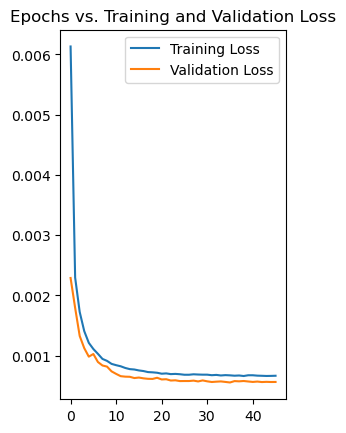

In [14]:
plot_model_rmse_and_loss(history)

In [28]:
# Function to build lstm-model with hyperparameters
def build_lstm_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2]))) # Separate input shape definition to avoid Keras warning

    #lstm_layer
    model.add(LSTM(
        units=hp.Int('lstm_units', min_value=16, max_value=128, step=16)
    ))

    # Dropout layer for the lstm-layer
    model.add(Dropout(
        rate=hp.Choice('dropout_rate_lstm', [0.1, 0.2, 0.3, 0.4, 0.5])
    ))

#   Second hiddden layer  
    model.add(Dense(
        units=hp.Int('dense_units', min_value=8, max_value=64, step=8),
        activation='relu'
    ))

    # Dropout layer for the second hidden layer
    model.add(Dropout(
        rate=hp.Choice('dropout_rate_dense', [0.0, 0.1, 0.2, 0.3, 0.4])
    ))

    # Output-layer
    model.add(Dense(1))

    # Adam Optimizer mit globalem Weight Decay
    optimizer = tf.optimizers.Adam(
        learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]),
        weight_decay=hp.Choice('weight_decay', [0.0, 1e-5, 1e-4, 1e-3])
    )

    model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
    return model

# Keras Tuner for LSTM
tuner = kt.Hyperband(
    build_lstm_model,  # Model-building function
    objective='val_loss',  # Objective: minimize validation loss
    max_epochs=15,  # Maximum number of epochs per trial
    factor=3,  # Each successive round reduces the number of trials by this factor
    hyperband_iterations=1,  # Number of Hyperband iterations
    distribution_strategy=tf.distribute.MirroredStrategy(),  # Use all available GPUs
    directory='keras_tuner_lstm',  # Directory for storing tuner results
    project_name='lstm_hyperband'  # Project name
)

# Execute tuning 
tuner.search(train_dataset, epochs=10, validation_data=val_dataset)

Trial 30 Complete [00h 01m 18s]
val_loss: 0.0006088260561227798

Best val_loss So Far: 0.0005341802607290447
Total elapsed time: 00h 13m 25s


In [29]:
#Collect best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best LSTM units: {best_hps.get('lstm_units')}")
print(f"Best dense layer units: {best_hps.get('dense_units')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")
print(f"Best dropout rate (LSTM): {best_hps.get('dropout_rate_lstm')}")
print(f"Best dropout rate (dense): {best_hps.get('dropout_rate_dense')}")
print(f"Best Global weight decay: {best_hps.get('weight_decay')}")

# Train best model
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("lstm_best.keras", monitor= "val_loss", save_best_only=True)
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(train_dataset, epochs=50, validation_data=(val_dataset), verbose = 1, callbacks = [early_stopping, model_checkpoint])


Best LSTM units: 128
Best dense layer units: 48
Best learning rate: 0.001
Best dropout rate (LSTM): 0.3
Best dropout rate (dense): 0.0
Best Global weight decay: 0.0001
Epoch 1/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0120 - mse: 0.0120 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 2/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 3/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 9.3735e-04 - val_mse: 9.3735e-04
Epoch 4/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 8.9153e-04 - val_mse: 8.9153e-04
Epoch 5/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 7.4589e-04 - val_mse: 7.4589e-04
Epoch 6/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 9.2917e-04 - mse: 9.2917e-04 - val_loss: 6.1907e-04 - val_mse: 6.1907e-04
Epoch 7/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 8.4489e-04 - mse:

In [30]:
print(X_train.shape)

(27024, 24, 17)


In [31]:
print(f"Best dropout rate (LSTM): {best_hps.get('dropout_rate_lstm')}")
print(f"Best dropout rate (dense): {best_hps.get('dropout_rate_dense')}")

Best dropout rate (LSTM): 0.3
Best dropout rate (dense): 0.0


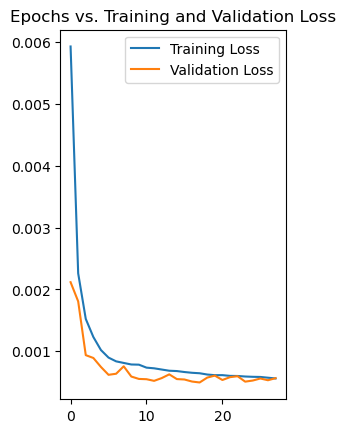

In [32]:
plot_model_rmse_and_loss(history)

In [33]:
lstm_model_best = load_model("lstm_best.keras")
predictions = lstm_model_best.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE: {rmse:.4f}')

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
RMSE: 0.0209


845/845 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


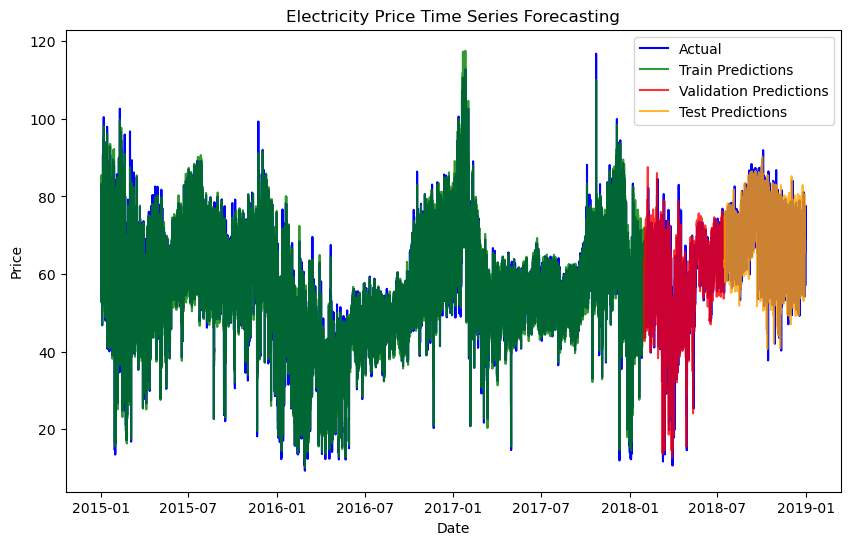

In [35]:
# Make predictions
train_predictions = lstm_model_best.predict(X_train)
validation_predictions = lstm_model_best.predict(X_val)
test_predictions = lstm_model_best.predict(X_test)

# Inverse transform the predictions
train_predictions = scaler_y.inverse_transform(train_predictions)
validation_predictions = scaler_y.inverse_transform(validation_predictions)
test_predictions = scaler_y.inverse_transform(test_predictions)

# Plot predictions
plt.figure(figsize=(10, 6))

# Plot actual data
seq_length = 24
plt.plot(df_final_viz.index[seq_length:], df_final_viz['price actual'][seq_length:], label='Actual', color='blue')

# Plot training predictions
plt.plot(df_final_viz.index[seq_length:seq_length+len(train_predictions)], train_predictions, label='Train Predictions',color='green', alpha = 0.8)

# Plot validation predictions
validation_pred_index = range(seq_length+len(train_predictions), seq_length+len(train_predictions)+len(validation_predictions))
plt.plot(df_final_viz.index[validation_pred_index], validation_predictions, label='Validation Predictions',color='red', alpha = 0.8)

# Plot testing predictions
test_pred_index = range(seq_length+len(train_predictions)+len(validation_predictions), seq_length+len(train_predictions)+len(validation_predictions)+len(test_predictions))
plt.plot(df_final_viz.index[test_pred_index], test_predictions, label='Test Predictions',color='orange', alpha = 0.8)

plt.title('Electricity Price Time Series Forecasting')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
